<a href="https://colab.research.google.com/github/eminshall/Demand_Forecasting/blob/main/Demand_Forecasting_Using_ARIMA_SARIMAX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Step 1: Load the Data and Filter Data

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
plt.style.use('ggplot')

from google.colab import drive

from datetime import datetime
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Load Dataset
data_raw = pd.read_csv('/content/drive/MyDrive/online_retail_II.csv')
data = pd.DataFrame(data_raw)

data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [ ]:
# Change Column name
data = data.rename(columns = {'InvoiceDate': 'Date'})

In [ ]:
#Our data doesn't have a sales column so we need to make one
data['Sales'] = data.Price * data.Quantity

data.head()

,Invoice,StockCode,Description,Quantity,Date,Price,Customer ID,Country,Sales
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0


In [ ]:
# Select One item with > 2000 rows
data = data[data['StockCode'] == '21232']
data.head()

,Invoice,StockCode,Description,Quantity,Date,Price,Customer ID,Country,Sales
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.00
231,489461,21232,STRAWBERRY CERAMIC TRINKET BOX,48,2009-12-01 10:49:00,1.25,17865.0,United Kingdom,60.00
841,489536,21232,STRAWBERRY CERAMIC TRINKET BOX,3,2009-12-01 12:13:00,1.25,16393.0,United Kingdom,3.75
910,489537,21232,STRAWBERRY CERAMIC TRINKET BOX,20,2009-12-01 12:14:00,1.25,14040.0,United Kingdom,25.00
1004,489546,21232,STRAWBERRY CERAMIC TRINKET BOX,12,2009-12-01 12:30:00,1.25,14156.0,EIRE,15.00


In [ ]:
#Drop features that are the same for every row
data = data.drop(['Description','Invoice','StockCode'], axis=1)

data.head()

,Quantity,Date,Price,Customer ID,Country,Sales
4,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.00
231,48,2009-12-01 10:49:00,1.25,17865.0,United Kingdom,60.00
841,3,2009-12-01 12:13:00,1.25,16393.0,United Kingdom,3.75
910,20,2009-12-01 12:14:00,1.25,14040.0,United Kingdom,25.00
1004,12,2009-12-01 12:30:00,1.25,14156.0,EIRE,15.00


In [ ]:
data_copy = data.copy()

In [ ]:
#Reformat the Date to a lower resolution
data_copy['Date'] = pd.to_datetime(data_copy['Date']).dt.strftime('%Y-%m-%d')

data_copy['Date'] = pd.to_datetime(data_copy['Date'])
data_copy.head()

,Quantity,Date,Price,Customer ID,Country,Sales
4,24,2009-12-01,1.25,13085.0,United Kingdom,30.00
231,48,2009-12-01,1.25,17865.0,United Kingdom,60.00
841,3,2009-12-01,1.25,16393.0,United Kingdom,3.75
910,20,2009-12-01,1.25,14040.0,United Kingdom,25.00
1004,12,2009-12-01,1.25,14156.0,EIRE,15.00


In [ ]:
data_copy.dtypes

Quantity                int64
Date           datetime64[ns]
Price                 float64
Customer ID           float64
Country                object
Sales                 float64
dtype: object

In [ ]:
df = data_copy.groupby(data_copy.Date.dt.date).agg({'Sales': 'sum'}).reset_index()

In [ ]:
# Set Date as Index
df.set_index('Date', inplace=True)

df.head()

,Sales
Date,
2009-12-01,259.59
2009-12-02,252.03
2009-12-03,283.55
2009-12-04,321.95
2009-12-05,45.00


In [ ]:
#One thing we can do is add dates to our missing sections and input 0 sales made that day-- which is true
Dates = pd.Series(pd.date_range('2009-12-01', end='2011-12-09', freq='D'))

In [ ]:
Dates.head()

0   2009-12-01
1   2009-12-02
2   2009-12-03
3   2009-12-04
4   2009-12-05
dtype: datetime64[ns]

In [ ]:
ts = df.reindex(Dates, fill_value=0)
ts.head(15)

,Sales
2009-12-01,259.59
2009-12-02,252.03
2009-12-03,283.55
2009-12-04,321.95
2009-12-05,45.00
2009-12-06,67.50
2009-12-07,270.78
2009-12-08,426.40
2009-12-09,122.58
2009-12-10,270.64


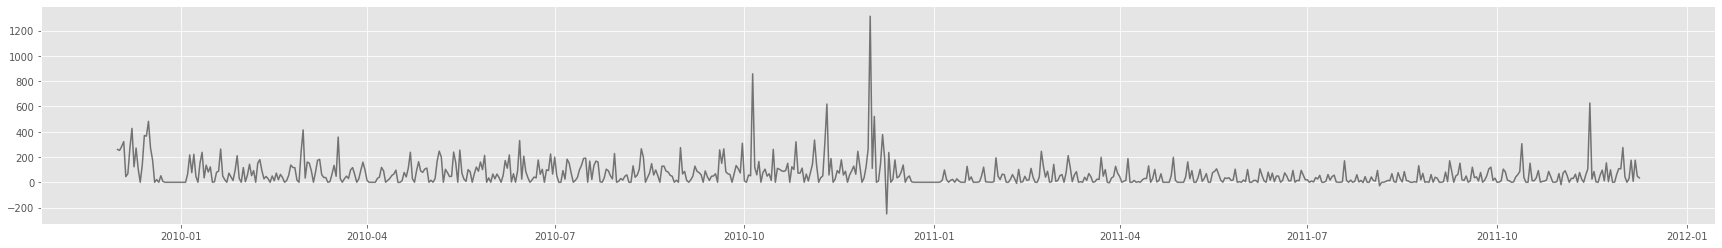

In [ ]:
#plot 
plt.figure(figsize=(30,4))
plt.plot(ts, color='black', alpha=0.5)
plt.show()

# Step 2: Analyze Data Properties & Feasibility



We first check whether the data is stationary, that is:

* The mean is constant
* The variance is constant
* Covarience doesn't depend on time (no trends or seasonality, but cycles can be present)



In [ ]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries, mean_window = 7, var_window = 7):
    # Determing rolling statistics
    rolmean = timeseries.rolling(window = mean_window).mean()
    rolstd = timeseries.rolling(window = var_window).std()

    # Plot rolling statistics:
    plt.figure(figsize=(30,4))
    orig = plt.plot(timeseries, color='black', label='Original', alpha=0.5)
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='orange', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Perform Dickey-Fuller test:
    print('Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

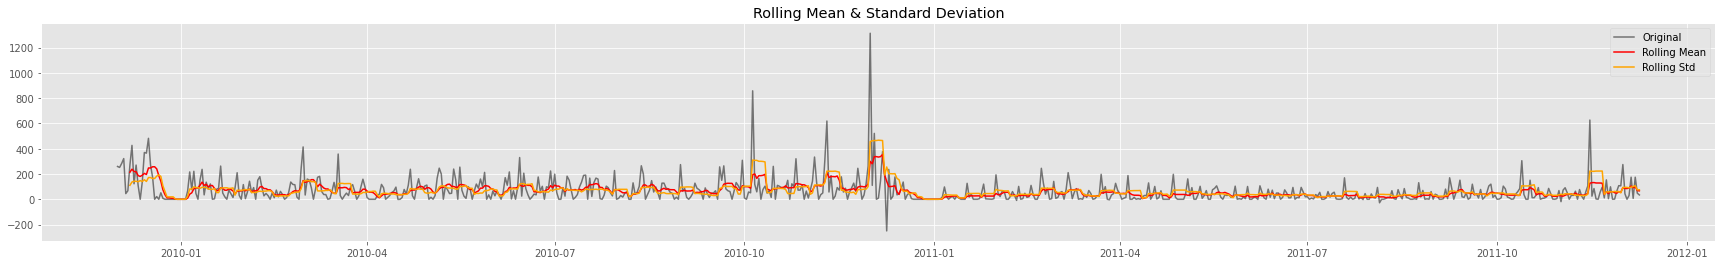

Dickey-Fuller Test:
Test Statistic                  -4.444157
p-value                          0.000248
#Lags Used                      20.000000
Number of Observations Used    718.000000
Critical Value (1%)             -3.439490
Critical Value (5%)             -2.865574
Critical Value (10%)            -2.568918
dtype: float64


In [ ]:
test_stationarity(ts)

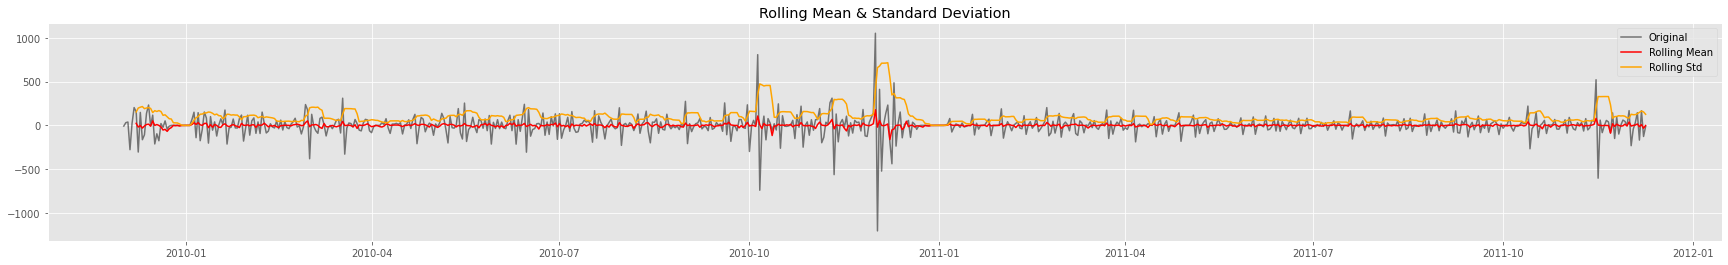

Dickey-Fuller Test:
Test Statistic                -1.097398e+01
p-value                        7.752704e-20
#Lags Used                     1.900000e+01
Number of Observations Used    7.180000e+02
Critical Value (1%)           -3.439490e+00
Critical Value (5%)           -2.865574e+00
Critical Value (10%)          -2.568918e+00
dtype: float64


In [ ]:
#The next step is to differentiate the time series and assess the stationarity characteristics again.

ts_diff = ts - ts.shift(1)
ts_diff.dropna(inplace=True)
test_stationarity(ts_diff)

#Step 3: Parameter Estimation

The next step is to compute autocorrelation (ACF) and partial autocorrelation (PACF) functons. ACF/PACF properties will be used to pick proper ARIMA and SARIMA parameters p, d, q. Refer to Part 1 for a theoretical background.

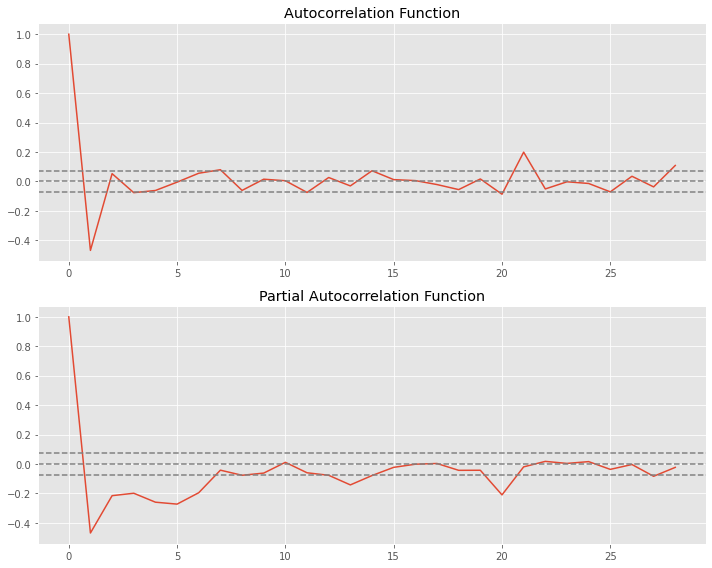

In [ ]:
from statsmodels.tsa.stattools import acf, pacf

acf = acf(ts_diff, nlags=28)
pacf = pacf(ts_diff, nlags=28, method='ols')

fig, ax = plt.subplots(2, 1, sharey=True, figsize=(10, 8))

for i, (ac, ac_name) in enumerate([(acf, 'Autocorrelation Function'), (pacf, 'Partial Autocorrelation Function')]):
    ax[i].plot(ac)
    ci_boundary = 1.96/np.sqrt(len(ts_diff))
    for ci_line in [0, -ci_boundary, ci_boundary]:
        ax[i].axhline(y=ci_line, linestyle='--', color='gray')
    ax[i].title.set_text(ac_name)
    
plt.tight_layout()



We make the following choices for ARIMA model parameters:

* We choose the difference parameter d to be 1 based on the previous analysis that shown that the differenciated series is stationary.
* We set parameter p for AR(p) process to 6 becasue PACF cuts off at this point, except seasonal spikes.
* We set parameter q for MA(q) process to 2, based on the ACF. This exludes seasonal spikes as well.





---

# Step 4: Fitting ARIMA

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace import sarimax
from sklearn.metrics import mean_squared_error

In [ ]:
arima_model = ARIMA(endog=ts, order=(7, 1, 2), freq='D').fit()
fitted_values_arima = arima_model.predict(typ='levels')

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


<ipython-input-26-01be5ef5e508>:2: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  plt.plot(ts['2010'], color='black', alpha=0.5)


Text(0.5, 1.0, 'MSE: 8884.68')

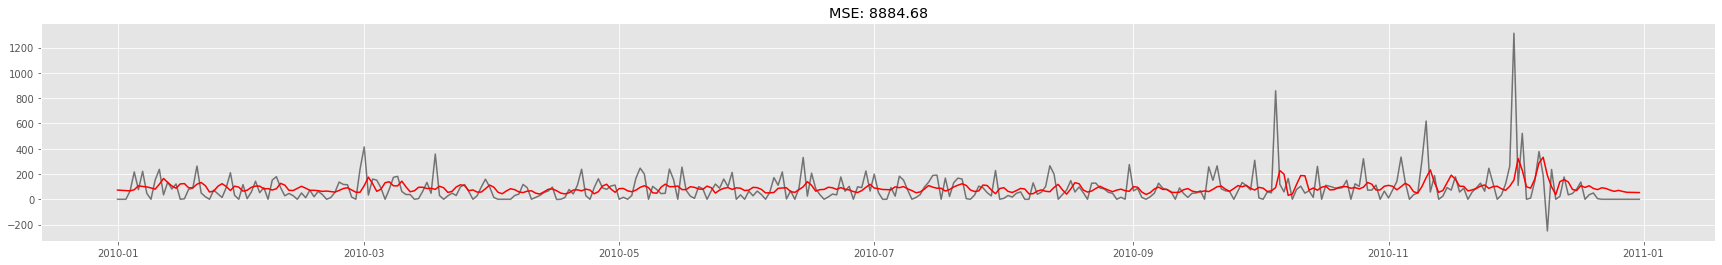

In [ ]:
plt.figure(figsize=(30,4))
plt.plot(ts['2010'], color='black', alpha=0.5)
plt.plot(fitted_values_arima['2010'], color='red')
mse = mean_squared_error(fitted_values_arima, ts)
plt.title(f'MSE: {mse:.2f}')

---

# Step 5: Fitting SARIMAX

In [ ]:
sarimax_model = sarimax.SARIMAX(endog=ts, trend='c', freq='D', order=(7, 0, 2), seasonal_order=(1, 0, 1, 30)).fit(disp=False)
fitted_values_sarimax = sarimax_model.predict(typ='levels')

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<ipython-input-28-ba2b012fd95b>:2: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  plt.plot(ts['2010'].shift(), color='black', alpha=0.5)


Text(0.5, 1.0, 'MSE: 6907.20')

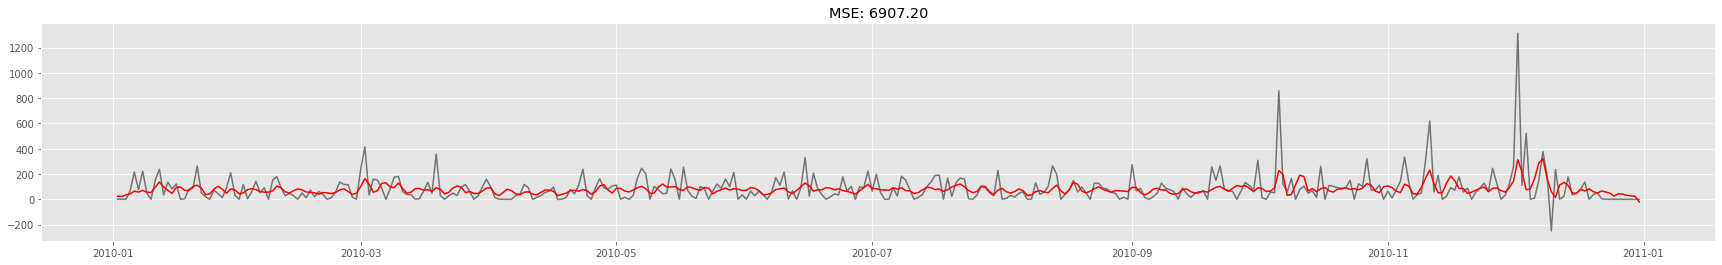

In [ ]:
plt.figure(figsize=(30, 4))
plt.plot(ts['2010'].shift(), color='black', alpha=0.5)
plt.plot(fitted_values_sarimax['2010'][1:], color='red')
mse = mean_squared_error(fitted_values_sarimax[1:], ts.shift()[1:])
plt.title(f'MSE: {mse:.2f}')

---

# Step 6: Checking for Residuals

In [ ]:
from scipy import stats
from scipy.stats import normaltest
import seaborn as sns
import statsmodels.api as sm

NormaltestResult(statistic=728.1733246831817, pvalue=7.571320149087204e-159)


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


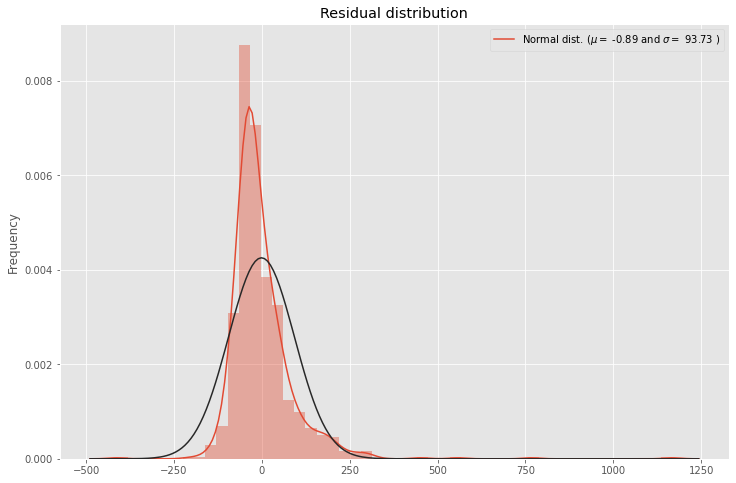

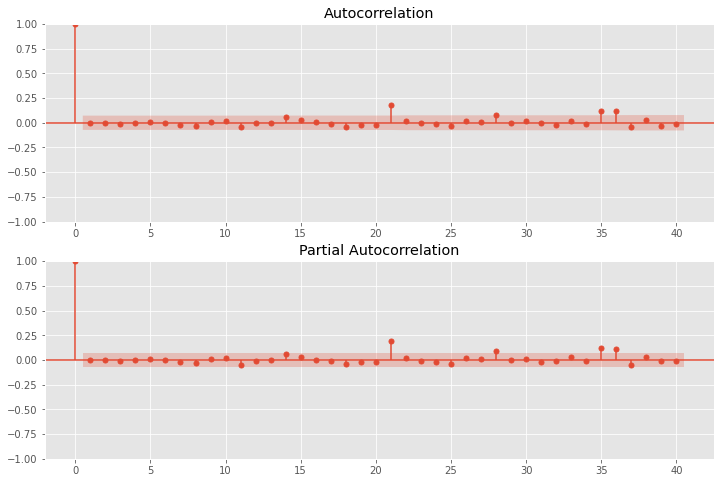

In [ ]:
def plot_residuals(residuals): 
    print(normaltest(residuals))

    fig = plt.figure(figsize=(12,8))
    ax0 = fig.add_subplot(111)

    # Plot the distribution
    sns.distplot(residuals ,fit = stats.norm, ax = ax0)
    (mu, sigma) = stats.norm.fit(residuals)  
    plt.legend([f'Normal dist. ($\mu=$ {mu:.2f} and $\sigma=$ {sigma:.2f} )'], loc='best')
    plt.ylabel('Frequency')
    plt.title('Residual distribution')

    # ACF and PACF
    fig = plt.figure(figsize=(12,8))
    ax1 = fig.add_subplot(211)
    fig = sm.graphics.tsa.plot_acf(residuals, lags=40, ax=ax1)
    ax2 = fig.add_subplot(212)
    fig = sm.graphics.tsa.plot_pacf(residuals, lags=40, ax=ax2)
    
plot_residuals(sarimax_model.resid)

---

# Step 7: Out of Sample Forecast

<ipython-input-31-523fd5b83616>:7: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  plt.plot(ts['2011'], color='black', alpha=0.5)


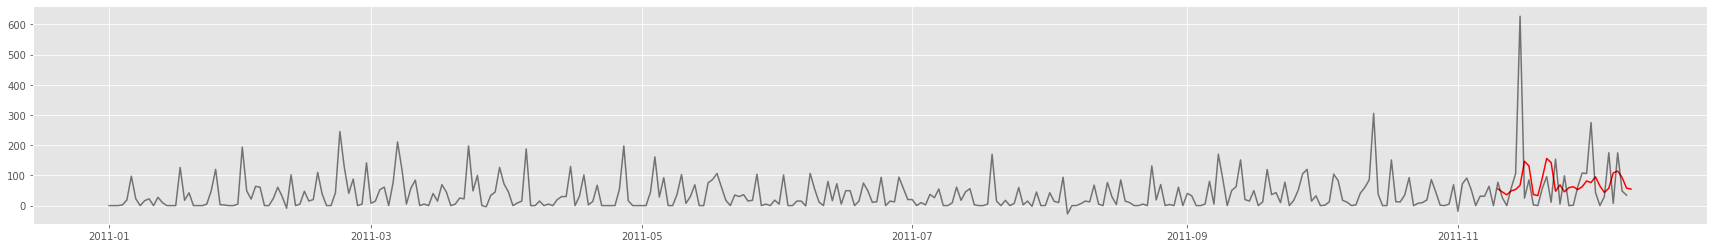

In [ ]:
# In sample forecasting
n = len(sarimax_model.fittedvalues) 
predicted = sarimax_model.predict(n - 30, n)

plt.figure(figsize=(30, 4))
plt.plot(predicted, color='red')
plt.plot(ts['2011'], color='black', alpha=0.5)

<AxesSubplot:>

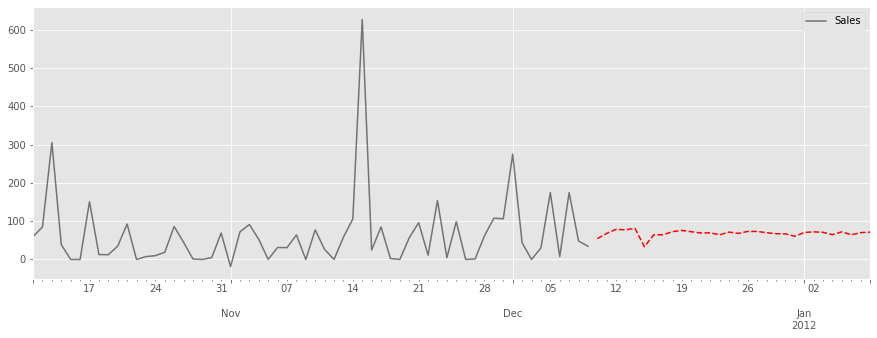

In [ ]:
# Out of sample forecasting
fcast = sarimax_model.get_forecast(30).summary_frame()
fig, ax = plt.subplots(figsize=(15, 5))
ts[-60:].plot(ax = ax, color='black', alpha=0.5)
fcast['mean'].plot(ax = ax, style='r--')

--- 

# Step 8: Improving Model with Exogenous Features

The next step is to improve the results using exogenous features like holidays, weekends, and pre/post holiday day indicators.

In [ ]:
ts.head()

,Sales
2009-12-01,259.59
2009-12-02,252.03
2009-12-03,283.55
2009-12-04,321.95
2009-12-05,45.00


In [ ]:
train_df = ts.asfreq(freq ='D') 
train_df['date'] = train_df.index
train_df['year'] = train_df['date'].dt.year - 2008
train_df['month'] = train_df['date'].dt.month
train_df['day'] = train_df['date'].dt.dayofyear
train_df['weekday'] = train_df['date'].dt.weekday

In [ ]:
train_df

,Sales,date,year,month,day,weekday
2009-12-01,259.59,2009-12-01,1,12,335,1
2009-12-02,252.03,2009-12-02,1,12,336,2
2009-12-03,283.55,2009-12-03,1,12,337,3
2009-12-04,321.95,2009-12-04,1,12,338,4
2009-12-05,45.00,2009-12-05,1,12,339,5
...,...,...,...,...,...,...
2011-12-05,174.82,2011-12-05,3,12,339,0
2011-12-06,7.38,2011-12-06,3,12,340,1
2011-12-07,174.67,2011-12-07,3,12,341,2
2011-12-08,48.35,2011-12-08,3,12,342,3


In [ ]:
holiday = pd.read_csv('/content/drive/MyDrive/US Holiday Dates (2004-2021).csv')
holiday.head()

,Date,Holiday,WeekDay,Month,Day,Year
0,2004-07-04,4th of July,Sunday,7,4,2004
1,2005-07-04,4th of July,Monday,7,4,2005
2,2006-07-04,4th of July,Tuesday,7,4,2006
3,2007-07-04,4th of July,Wednesday,7,4,2007
4,2008-07-04,4th of July,Friday,7,4,2008


In [ ]:
#Make Holiday Date into a datetime type
holiday = holiday.rename(columns = {'Date': 'date'})
holiday = holiday.drop(['WeekDay','Month','Day','Year'], axis=1)
holiday['date'] = pd.to_datetime(holiday['date'], yearfirst = True, format = '%Y-%m-%d')

# remove unused holidays
holiday = holiday[holiday['date'] >= '2009-12-01']
holiday = holiday[holiday['date'] < '2011-12-04']

holiday.head()

,date,Holiday
6,2010-07-04,4th of July
7,2011-07-04,4th of July
23,2009-12-25,Christmas Day
24,2010-12-25,Christmas Day
41,2009-12-24,Christmas Eve


In [ ]:
#Merge holiday with df_train
train_df = train_df.merge(holiday, how='left', on='date')

#Create Dummy Vectors for Object information
train_df['holiday_bool'] = pd.notnull(train_df['Holiday']).astype(int)
train_df = pd.get_dummies(train_df, columns = ['month', 'Holiday', 'weekday'] , prefix = ['month', 'holiday', 'weekday'])

train_df.head()

,Sales,date,year,day,holiday_bool,month_1,month_2,month_3,month_4,month_5,...,holiday_Veterans Day,holiday_Washington's Birthday,holiday_Western Easter,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,259.59,2009-12-01,1,335,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,252.03,2009-12-02,1,336,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,283.55,2009-12-03,1,337,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,321.95,2009-12-04,1,338,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,45.00,2009-12-05,1,339,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [ ]:
exog_data = train_df.drop(columns=['Sales'], inplace=False, axis=1)
exog_data = exog_data.set_index('date')
train_df = train_df.set_index('date')

In [ ]:
sarimax_exog_model = sm.tsa.statespace.SARIMAX(endog = train_df.Sales,
                                        exog = exog_data,  
                                        trend='n', 
                                        order=(7, 0, 2), 
                                        seasonal_order=(1, 0, 1, 30)).fit()

fitted_values_sarimax_exog = sarimax_exog_model.predict(typ='levels')

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<ipython-input-41-9a338b3be399>:3: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  plt.plot(ts[plot_year].shift(), color='black', alpha=0.5, label='Ground truth')
<ipython-input-41-9a338b3be399>:7: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  mse_endog = mean_squared_error(fitted_values_sarimax[plot_year][1:], ts[plot_year].shift()[1:])
<ipython-input-41-9a338b3be399>:8: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  mse_exog = mean_squared_error(fitted_values_sarimax_exog[plot_year][1:], t

Text(0.5, 1.0, 'MSE: SARIMAX Endogenous 2849.13, SARIMAX Exogeneous: 3407.05')

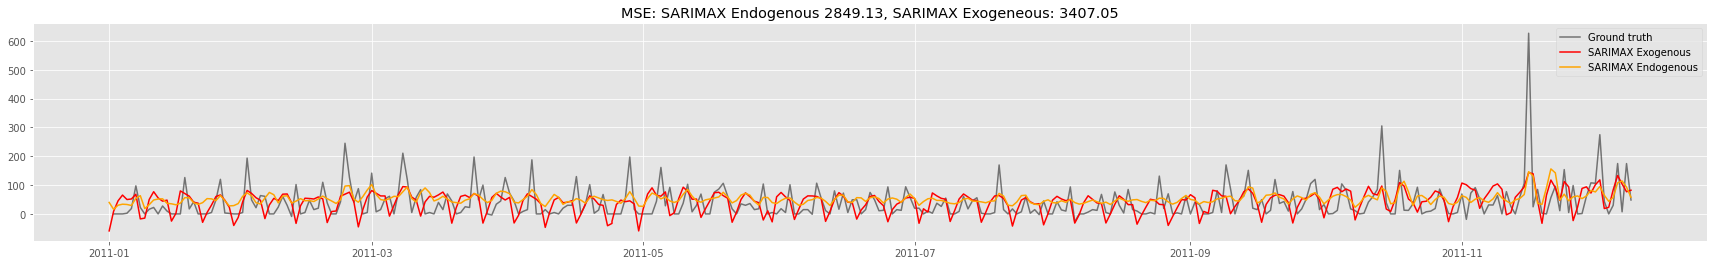

In [ ]:
plot_year = '2011'
plt.figure(figsize=(30, 4))
plt.plot(ts[plot_year].shift(), color='black', alpha=0.5, label='Ground truth')
plt.plot(fitted_values_sarimax_exog[plot_year], color='red', label='SARIMAX Exogenous')
plt.plot(fitted_values_sarimax[plot_year], color='orange', label='SARIMAX Endogenous')
plt.legend()
mse_endog = mean_squared_error(fitted_values_sarimax[plot_year][1:], ts[plot_year].shift()[1:])
mse_exog = mean_squared_error(fitted_values_sarimax_exog[plot_year][1:], ts[plot_year])
plt.title(f'MSE: SARIMAX Endogenous {mse_endog:.2f}, SARIMAX Exogeneous: {mse_exog:.2f}')

---

# Step 9: Check the Residuals of SARIMAX Exogenous

NormaltestResult(statistic=764.3958539254029, pvalue=1.0316902475778468e-166)


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


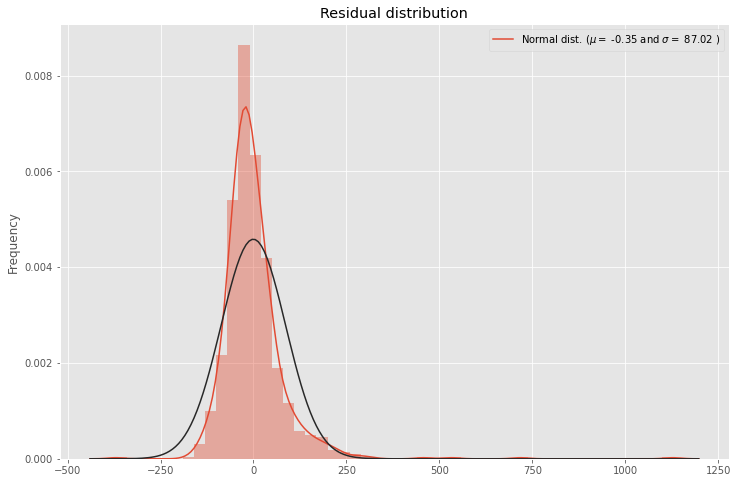

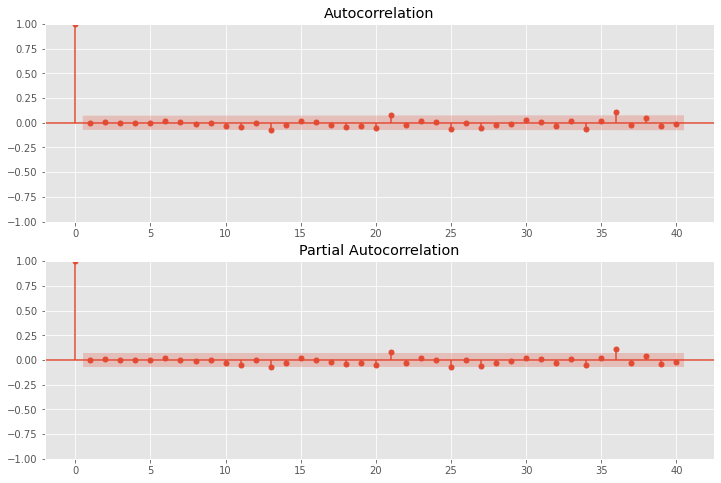

In [ ]:
resid = plot_residuals(sarimax_exog_model.resid)